In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
sns.set('notebook')

def select_score_features(score):
    return score.drop(columns=['category', 'age']).dropna(how='any')

def select_genetics_features(genetics):
    return genetics.drop(columns=['name', 'level_0'])

def select_milk_features(milk):
    return milk[['animal_id','date','milk_weight']]

def retrieve_data():
    engine =  create_engine('sqlite:///../data/database/happycows.db')
    with engine.connect() as con:
        score = pd.read_sql_table('classification', con)
        genetics = pd.read_sql_table('genetics', con)
        milk = pd.read_sql_table('milk_volume', con)
    return select_score_features(score), select_genetics_features(genetics), select_milk_features(milk)

In [2]:
score, genetics, milk = retrieve_data()

In [3]:
def get_totals_for_time_period(milk, start, end):
    date_mask = (milk['date'] >= start) & (milk['date'] <= end)
    milk = milk[date_mask]
    milk_totals = milk.groupby(['animal_id']).sum()['milk_weight'].sort_values(ascending=False)
    return milk_totals.reset_index()

def plot_top_producers(milk, start, end, top_quantile=0.25):
    milk_totals = get_totals_for_time_period(milk, start, end)
    
    target_quantile = 1 - top_quantile
    target_milk = milk_totals['milk_weight'].quantile(target_quantile)
    data = milk_totals[milk_totals['milk_weight'] > target_milk]
    
    a4_dims = (15.7, 4.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    
    ax = sns.barplot(ax=ax, y='milk_weight', x='animal_id', data=data, palette=sns.color_palette(n_colors=1))
    _ = plt.xticks(rotation='vertical')
    _ = plt.xlabel('Animal ID')
    _ = plt.ylabel('Milk Weight Produced (lb)')
    
    percentile = top_quantile * 100
    _ = plt.title(f'Top {percentile}% Animals by Total Milk Weight {start} to {end}')
    
    top_quarter = milk_totals['milk_weight'].quantile(0.75)
    line_25 = ax.axhline(top_quarter, ls='--', c='#ffeda0', label='Top 25%')
    
    top_half = milk_totals['milk_weight'].quantile(0.50)
    line_50 = ax.axhline(top_half, ls='--', c='#feb24c', label='Top 50%')
    
    top_three_quarters = milk_totals['milk_weight'].quantile(0.25)
    line_75 = ax.axhline(top_three_quarters, ls='--', c='#f03b20', label='Top 75%')
    
    plt.legend([line_25, line_50, line_75], 
               [f'Top 25% ({int(top_quarter)} lb)',
                f'Top 50% ({int(top_half)} lb)',
                f'Top 75% ({int(top_three_quarters)} lb)'], 
               loc='best')
    return data

## Top Producers for 2016

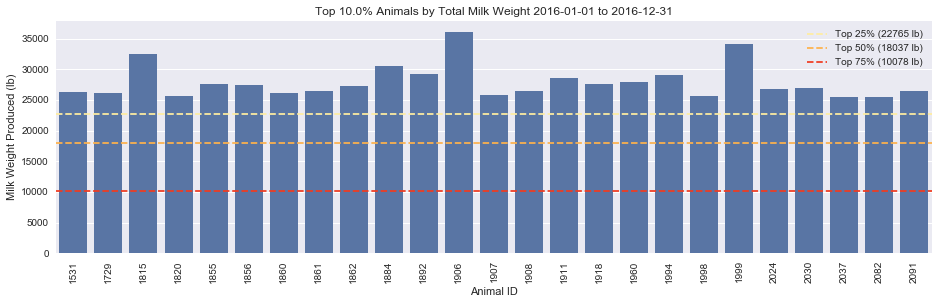

In [4]:
top_2016 = plot_top_producers(milk, '2016-01-01', '2016-12-31', top_quantile=0.1).reset_index()
plt.savefig('../reports/figures/top_producer_2016.png', dpi=300, bbox_inches='tight')
plt.show()

## Top Producers for 2017

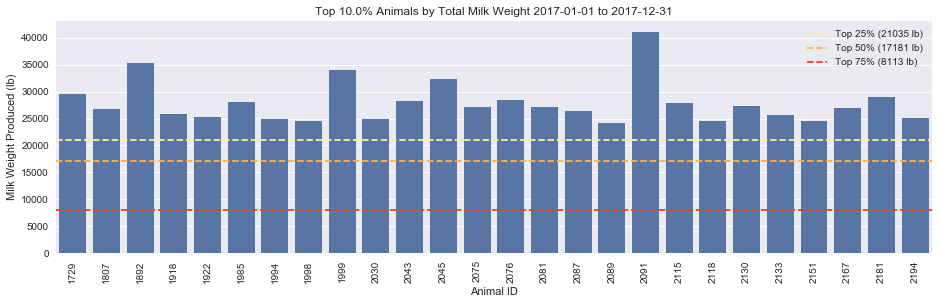

In [5]:
top_2017 = plot_top_producers(milk, '2017-01-01', '2017-12-31', top_quantile=0.1).reset_index()
plt.savefig('../reports/figures/top_producer_2017.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
#Repeat Performers

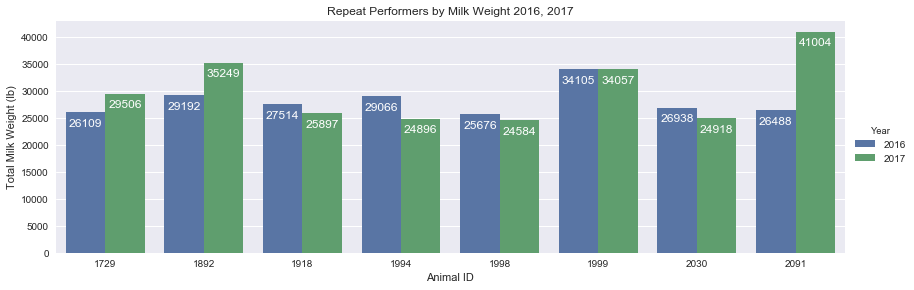

In [7]:
import numpy as np
repeat_performers = np.intersect1d(top_2016['animal_id'], top_2017['animal_id'])

def plot_milk_comparison(animal_ids, m1, m2, m1_year=2016, m2_year=2017):
    m1 = m1[m1['animal_id'].isin(animal_ids)].set_index('animal_id')['milk_weight'].reset_index()
    m1['Year'] = m1_year
    m2 = m2[m2['animal_id'].isin(animal_ids)].set_index('animal_id')['milk_weight'].reset_index()
    m2['Year'] = m2_year
    m = m1.append(m2)
    
    # Draw a nested barplot 
    ax = sns.factorplot(x="animal_id", y="milk_weight", hue="Year", data=m, kind="bar", size=4, aspect=3)
    _ = plt.xlabel('Animal ID')
    _ = plt.ylabel('Total Milk Weight (lb)')
    _ = plt.title('Repeat Performers by Milk Weight 2016, 2017')
    ax = plt.gca()
    for p in ax.patches:
        _ = ax.text(p.get_x() + p.get_width()/2., 
                    p.get_height() - 3000, 
                    '%d' % int(p.get_height()), 
                    fontsize=12, color='white', ha='center', va='bottom')
    return ax
    
ax = plot_milk_comparison(repeat_performers, top_2016, top_2017, 2016, 2017)
plt.savefig('figures/repeat_performers.png', dpi=300, bbox_inches='tight')
plt.show()